In [3]:
import os
folder_path = '/kaggle/input/realwaste/realwaste-main/RealWaste'
os.chdir(folder_path)
print("Contents:", os.listdir(folder_path))

Contents: ['Metal', 'Glass', 'Paper', 'Vegetation', 'Cardboard', 'Textile Trash', 'Food Organics', 'Plastic', 'Miscellaneous Trash']


In [4]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler
import time
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomRotation((0, 180)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(root=folder_path, transform = transform)
dataset_size = len(dataset)

indices = list(range(dataset_size))
random.seed(42)
random.shuffle(indices)

test_split = int(0.1 * dataset_size)
val_split = int(0.1 * dataset_size)


test_indices = indices[:test_split]
val_indices = indices[test_split:test_split + val_split]
train_indices = indices[test_split + val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(dataset, batch_size=128, sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset, batch_size=128, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=128, sampler=test_sampler, num_workers=4, pin_memory=True)

In [5]:
import torch.nn as nn
import torch.optim as optim
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)

num_classes = len(dataset.classes)
# model.fc = model.fc = nn.Linear(model.fc.in_features, num_classes)
model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, num_classes))

model = model.to(device)

class_counts = Counter([label for _, label in dataset.samples])
class_counts_values = torch.tensor(list(class_counts.values()), dtype=torch.float)
class_weights = 1.0 / class_counts_values
class_weights = class_weights / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

In [6]:
for images, labels in val_loader:
    print(f"Sample Validation Labels: {labels[:10].tolist()}")
    break

#val_labels = [label for _, label in dataset.samples if _ in val_sampler.indices]
val_labels = [dataset.samples[i][1] for i in val_sampler.indices]
from collections import Counter
val_class_counts = Counter(val_labels)
print(f"Validation Class Distribution: {val_class_counts}")

Sample Validation Labels: [3, 4, 8, 3, 2, 8, 2, 7, 1, 5]
Validation Class Distribution: Counter({6: 86, 3: 75, 4: 52, 5: 52, 8: 47, 0: 47, 2: 42, 7: 38, 1: 36})


In [7]:
num_epochs = 20

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}/{num_epochs}...")  # Debug point 1

    model.train()
    train_loss = 0.0
    train_correct = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
      print(f"Processing batch {batch_idx + 1}/{len(train_loader)}")  # Debug point 2

      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * images.size(0)
      train_correct += (outputs.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_sampler.indices)
    train_acc = train_correct / len(train_sampler.indices)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(dim = 1) == labels).sum().item()

    val_loss /= len(val_sampler.indices)
    val_acc = val_correct / len(val_sampler.indices)


    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    scheduler.step(val_loss)

Starting epoch 1/20...
Processing batch 1/30
Processing batch 2/30
Processing batch 3/30
Processing batch 4/30
Processing batch 5/30
Processing batch 6/30
Processing batch 7/30
Processing batch 8/30
Processing batch 9/30
Processing batch 10/30
Processing batch 11/30
Processing batch 12/30
Processing batch 13/30
Processing batch 14/30
Processing batch 15/30
Processing batch 16/30
Processing batch 17/30
Processing batch 18/30
Processing batch 19/30
Processing batch 20/30
Processing batch 21/30
Processing batch 22/30
Processing batch 23/30
Processing batch 24/30
Processing batch 25/30
Processing batch 26/30
Processing batch 27/30
Processing batch 28/30
Processing batch 29/30
Processing batch 30/30
Epoch 1/20, Train Loss: 1.0194, Train Acc: 0.6368
Validation Loss: 0.8359, Validation Accuracy: 0.7011
Starting epoch 2/20...
Processing batch 1/30
Processing batch 2/30
Processing batch 3/30
Processing batch 4/30
Processing batch 5/30
Processing batch 6/30
Processing batch 7/30
Processing batch

In [11]:
train_correct = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()

train_acc = train_correct / len(train_indices)
print(f"Training Accuracy: {train_acc:.4f}")


# Evaluate on validation data
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        val_correct += (outputs.argmax(dim=1) == labels).sum().item()

val_acc = val_correct / len(val_indices)
print(f"Validation Accuracy: {val_acc:.4f}")


# Evaluate on test data
test_loss = 0.0
test_correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        test_correct += (outputs.argmax(dim=1) == labels).sum().item()

test_loss /= len(test_sampler.indices)
test_acc = test_correct / len(test_sampler.indices)

print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9947
Validation Accuracy: 0.9516
Test Accuracy: 0.9284


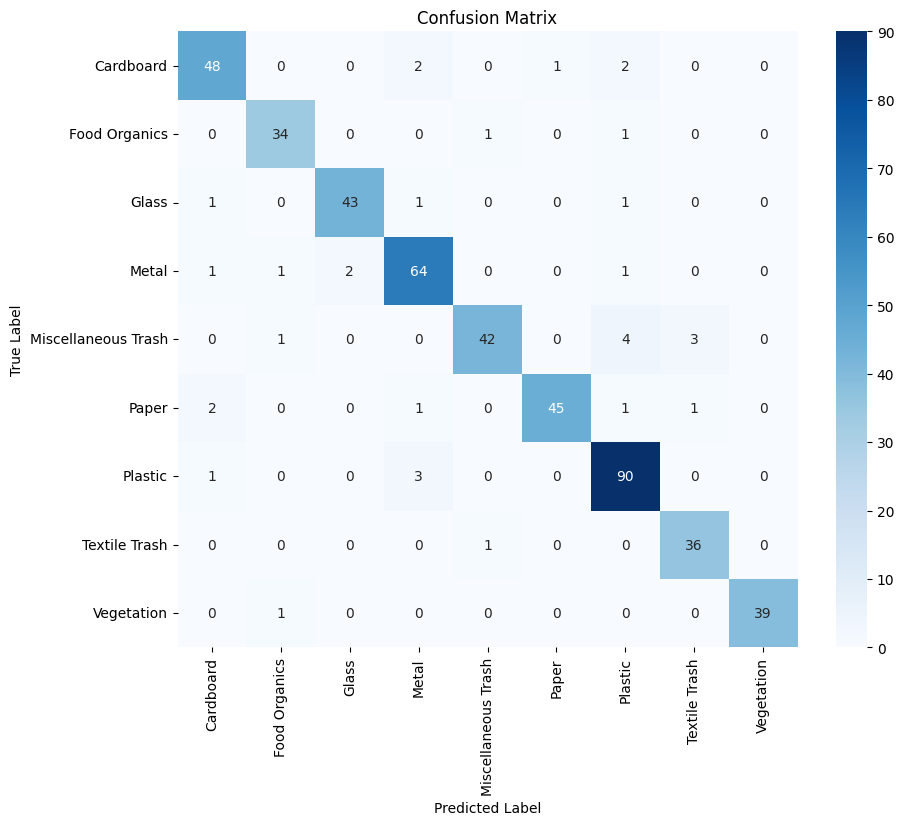

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

preds_list = []
labels_list = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim = 1)
        
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

cm = confusion_matrix(labels_list, preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()